In [1]:
%matplotlib inline

import os
import pandas
import numpy
import sklearn
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor


/Users/rsharp/PROJECTS/rws_project_python/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
polls_file_name = 'full_bracket.poll_of_polls.csv'
streak_file_name = 'composite_streak_data.csv'
points_file_name =  'team_points.csv'


polls = pandas.read_csv(polls_file_name, sep='|')
streak = pandas.read_csv(streak_file_name, sep='|').drop('Unnamed: 0', axis=1)
points = pandas.read_csv(points_file_name, sep='|').drop('Unnamed: 0', axis=1)

polls[:5]

,Team,rank,TeamID,norm_rank,Season,noise
0,Kansas,11.000000,1242,0.000000,2010,-0.388046
1,Kentucky,11.000000,1246,0.000000,2010,0.356803
2,Duke,11.000000,1181,0.000000,2010,0.019042
3,Syracuse,11.000000,1393,0.000000,2010,0.405093
4,West Virginia,11.555556,1452,0.010678,2010,-0.060610


In [3]:
root_path = 'data/kaggle_2018/DataFiles'

teams = pandas.read_csv(os.path.join(root_path, 'Teams.csv'))
slots = pandas.read_csv(os.path.join(root_path, 'NCAATourneySlots.csv'))
seeds = pandas.read_csv(os.path.join(root_path, 'NCAATourneySeeds.csv'))
results = pandas.read_csv(os.path.join(root_path, 'NCAATourneyCompactResults.csv'))

results['minID'] = results[['WTeamID', 'LTeamID']].min(axis=1)
results['maxID'] = results[['WTeamID', 'LTeamID']].max(axis=1)

In [4]:
# Load all historical tournament data
rounds_by_season = dict()

for season in range(2010, 2017+1):
    # initialize
    df = slots.merge(seeds, left_on=['Season', 'StrongSeed'], right_on=['Season', 'Seed'], how='left')
    df = df.rename(index=str, columns={"TeamID": "StrongTeamID"}).drop('Seed', axis=1)
    df = df.merge(seeds, left_on=['Season', 'WeakSeed'], right_on=['Season', 'Seed'], how='left')
    df = df.rename(index=str, columns={"TeamID": "WeakTeamID"}).drop('Seed', axis=1)

    # play-in games
    pi_games = ~(df['Slot'].str.contains('R')) & (df['Season'] == season)
    pi = df[pi_games]

    pi.loc[pi_games, 'minID'] = pi[['StrongTeamID', 'WeakTeamID']].min(axis=1)
    pi.loc[pi_games, 'maxID'] = pi[['StrongTeamID', 'WeakTeamID']].max(axis=1)

    pi = pi.merge(results, on=['Season', 'minID', 'maxID'], how='left')

    pi = pi.merge(teams[['TeamID', 'TeamName']], left_on=['StrongTeamID'], right_on=['TeamID'], how='left')
    pi = pi.rename(index=str, columns={"TeamName": "StrongTeamName"}).drop('TeamID', axis=1)
    pi = pi.merge(teams[['TeamID', 'TeamName']], left_on=['WeakTeamID'], right_on=['TeamID'], how='left')
    pi = pi.rename(index=str, columns={"TeamName": "WeakTeamName"}).drop('TeamID', axis=1)
    pi = pi.merge(teams[['TeamID', 'TeamName']], left_on=['WTeamID'], right_on=['TeamID'], how='left')
    pi = pi.rename(index=str, columns={"TeamName": "WTeamName"}).drop('TeamID', axis=1)
    pi = pi.merge(teams[['TeamID', 'TeamName']], left_on=['LTeamID'], right_on=['TeamID'], how='left')
    pi = pi.rename(index=str, columns={"TeamName": "LTeamName"}).drop('TeamID', axis=1)

    pi

    # regular rounds
    rounds = [pi]

    for rnd in range(1, 6 + 1):
        last_rnd = rounds[-1]

        r_games = (df['Slot'].str.contains('R{}..'.format(rnd))) & (df['Season'] == season)
        r = df[r_games]

        r = r.merge(last_rnd[['Slot', 'WTeamID']], left_on='StrongSeed', right_on='Slot', how='left', suffixes=['', '__'])
        r.loc[r['StrongTeamID'].isnull(), 'StrongTeamID'] = r['WTeamID']
        r = r.drop(['Slot__', 'WTeamID'], axis=1)

        r = r.merge(last_rnd[['Slot', 'WTeamID']], left_on='WeakSeed', right_on='Slot', how='left', suffixes=['', '__'])
        r.loc[r['WeakTeamID'].isnull(), 'WeakTeamID'] = r['WTeamID']
        r = r.drop(['Slot__', 'WTeamID'], axis=1)

        r['minID'] = r[['StrongTeamID', 'WeakTeamID']].min(axis=1)
        r['maxID'] = r[['StrongTeamID', 'WeakTeamID']].max(axis=1)

        r = r.merge(results, on=['Season', 'minID', 'maxID'], how='left')

        r = r.merge(teams[['TeamID', 'TeamName']], left_on=['StrongTeamID'], right_on=['TeamID'], how='left')
        r = r.rename(index=str, columns={"TeamName": "StrongTeamName"}).drop('TeamID', axis=1)
        r = r.merge(teams[['TeamID', 'TeamName']], left_on=['WeakTeamID'], right_on=['TeamID'], how='left')
        r = r.rename(index=str, columns={"TeamName": "WeakTeamName"}).drop('TeamID', axis=1)
        r = r.merge(teams[['TeamID', 'TeamName']], left_on=['WTeamID'], right_on=['TeamID'], how='left')
        r = r.rename(index=str, columns={"TeamName": "WTeamName"}).drop('TeamID', axis=1)
        r = r.merge(teams[['TeamID', 'TeamName']], left_on=['LTeamID'], right_on=['TeamID'], how='left')
        r = r.rename(index=str, columns={"TeamName": "LTeamName"}).drop('TeamID', axis=1)

        rounds.append(r.copy())
        
    rounds_by_season[season] = rounds

/Users/rsharp/PROJECTS/rws_project_python/lib/python2.7/site-packages/pandas/core/indexing.py:288: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/rsharp/PROJECTS/rws_project_python/lib/python2.7/site-packages/pandas/core/indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [53]:
def score_bracket(season, ranking, beta, historical_rounds, weights):
    # season: a year between 2010 and 2017 for which the ranking was created
    # ranking: ['TeamID', 'Rank'] - all D1 teams ranked as of the last day before the NCAA Tournament
    # historical_rounds: all historical NCAA tournament results by round between 2010 and 2017
    # weights: number of points to award per round in the scoring system 
    
    # Get the Tournament data for the indicated season
    rounds = historical_rounds[season]
    
    # Get the 64 teams in Round 1
    teams_64 = map(int, list(rounds[1]['StrongTeamID']) + list(rounds[1]['WeakTeamID']))

    # Get the bracket implied by the ranking
    bracket_64 = ranking[ranking['TeamID'].isin(teams_64)]
    initial_rank_64 = bracket_64['Rank'].copy()

    score = 0

    # First round - determine matchups and winners
    rnd = 1

    # Add noise to the rank each round
    bracket_64['Rank'] = initial_rank_64 + numpy.random.normal(scale=beta, size=bracket_64.shape[0]) 
    
    x = rounds[rnd].merge(bracket_64, left_on='WTeamID', right_on='TeamID', how='left')
    x = x.rename(index=str, columns={"Rank": "WTeamRank"}).drop('TeamID', axis=1)
    x = x.merge(bracket_64, left_on='LTeamID', right_on='TeamID', how='left')
    x = x.rename(index=str, columns={"Rank": "LTeamRank"}).drop('TeamID', axis=1)
    x['Correct'] = (x['WTeamRank'] < x['LTeamRank'])

    # Update score
    picked = x['Correct'].sum()
    score += weights[rnd]*picked
    # print rnd, x['Correct'].count(), picked, weights[rnd]*picked, total

    # Eliminate wrong picks
    my_remaining_teams = x[x['Correct'] == True]['WTeamID']

    # Remaining rounds - determine matchups and winners
    for rnd in range(2, 6+1):
        #my_remaining_bracket = bracket[bracket['TeamID'].isin(my_remaining_teams)]
        #my_remaining_bracket = ranking[ranking['TeamID'].isin(my_remaining_teams)]

        # Add noise to the rank each round
        #bracket_64['Rank'] = initial_rank_64 + numpy.random.normal(scale=beta/float(rnd), size=bracket_64.shape[0])
        bracket_64['Rank'] = initial_rank_64 + numpy.random.normal(scale=beta/numpy.power(2.0, rnd), size=bracket_64.shape[0])
        
        x = rounds[rnd].merge(bracket_64, left_on='WTeamID', right_on='TeamID', how='left')
        x = x.rename(index=str, columns={"Rank": "WTeamRank"}).drop('TeamID', axis=1)
        x = x.merge(bracket_64, left_on='LTeamID', right_on='TeamID', how='left')
        x = x.rename(index=str, columns={"Rank": "LTeamRank"}).drop('TeamID', axis=1)
        x['Correct'] = (x['WTeamRank'] < x['LTeamRank'])

        # Update score
        picked = x[x['WTeamID'].isin(my_remaining_teams)]['Correct'].sum()
        score += weights[rnd]*picked
        #print rnd, x['Correct'].count(), picked, weights[rnd]*picked, total

        # Eliminate wrong picks
        my_remaining_teams = x[(x['Correct'] == True) & (x['WTeamID'].isin(my_remaining_teams))]['WTeamID']

    return score

8.0

In [6]:
scores = list()

for season in range(2010, 2017+1):
    for i in range(20):
        bracket_file_name = 'bracket.combined.{}.{}.csv'.format(season, i)

        schema = [
            ('TeamID', int),
            ('Rank', float)
        ]

        bracket = pandas.read_csv(bracket_file_name, sep=' ', names=[x[0] for x in schema], dtype=dict(schema))
        


IOError: File bracket.combined.2010.0.csv does not exist

In [7]:
weights = {1: 1,
           2: 2,
           3: 4,
           4: 8,
           5: 16,
           6: 32}

score_bracket(season, bracket, rounds_by_season, weights)

NameError: name 'bracket' is not defined

In [8]:
import random



In [9]:
5*5*5

125

In [54]:
#n = 60
#trials = 10

n = 100
trials = 1

alpha_min = -1.0
alpha_max = 0.0
alpha_n = 100

beta_min = numpy.log(0.001)
beta_max = numpy.log(0.1)
beta_n   = n

h_model_data = dict([(f, list()) for f in ['Season', 'alpha', 'beta', 'score']])
#data = None

for season in range(2010, 2017+1):
    print season
    for alpha in [0.0]:
    #for alpha in numpy.linspace(-0.2, 0.2, n):
    # for alpha in numpy.random.random(alpha_n)*(alpha_max - alpha_min) + alpha_min: 
        for beta in numpy.linspace(0.01, 1.0, n):
        #for beta in numpy.logspace(-3.0, 0.0, n):
        #for beta in numpy.random.random(beta_n)*(beta_max - beta_min) + beta_min: 
        #for beta in numpy.exp(numpy.random.random(beta_n)*(beta_max - beta_min) + beta_min):
        #for beta in [0.0]:
            for i in range(trials):
                w = streak[(streak['Season'] == season) & (streak['StreakLen'] == 6)] \
                    .merge(polls[['TeamID', 'Season', 'norm_rank', 'noise']], on=['Season', 'TeamID'], how='left') \
                    .sort_values('norm_rank')

                #w['Rank'] = w['norm_rank'] - alpha*w['streak'] + beta*(numpy.random.random(w.shape[0]) - 0.5)
                #w['Rank'] = w['norm_rank'] - alpha*w['streak']
                #w['Rank'] = w['norm_rank'] + beta*(numpy.random.random(w.shape[0]) - 0.5)
                w['Rank'] = w['norm_rank'] 
                w['alpha'] = alpha
                w['beta'] = beta
                w['Season'] = season
                
                score = score_bracket(season, w[['TeamID', 'Rank']], beta, rounds_by_season, weights)
                
                # print season, alpha, beta, score

                h_model_data['Season'].append(season)
                h_model_data['alpha'].append(alpha)
                h_model_data['beta'].append(beta)
                h_model_data['score'].append(score)
                
                #if data is None:
                #    data = w[['alpha', 'beta', 'Season', 'TeamID', 'Rank']].copy()
                #else:
                #    data = data.append(w[['alpha', 'beta', 'Season', 'TeamID', 'Rank']].copy())
                    
h_model_data = pandas.DataFrame(h_model_data)

2010


/Users/rsharp/PROJECTS/rws_project_python/lib/python2.7/site-packages/ipykernel/__main__.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/rsharp/PROJECTS/rws_project_python/lib/python2.7/site-packages/ipykernel/__main__.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


2011
2012
2013
2014
2015
2016
2017


In [59]:
regr = AdaBoostRegressor(DecisionTreeRegressor(max_depth=6), n_estimators=500)

In [60]:
holdout_season = random.sample(range(2010, 2017+1), 1)[0]

X = h_model_data[h_model_data['Season'] != holdout_season][['beta']]
y = h_model_data[h_model_data['Season'] != holdout_season]['score']

print holdout_season
print X.shape

regr.fit(X, y)

2011
(700, 1)


AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mse', max_depth=6, max_features=None,
           max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best'),
         learning_rate=1.0, loss='linear', n_estimators=500,
         random_state=None)

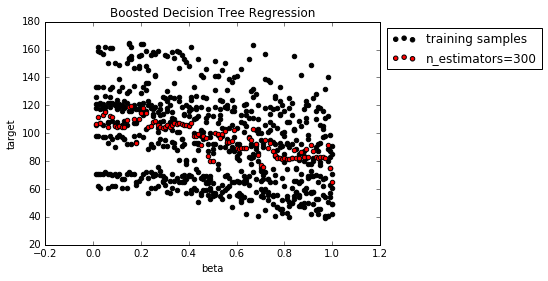

In [61]:
# randomness is necessary, but not much - it's generally a negative trend
# the right amount is the smallest amount possible that has any effect

y_pred = regr.predict(h_model_data[h_model_data['Season'] == holdout_season][['beta']])

axis_feature = 'beta'

plt.figure()
px, py = zip(*sorted(zip(X[axis_feature], y)))
plt.scatter(px, py, c="k", label="training samples")
px, py_pred = zip(*sorted(zip(X[axis_feature], y_pred)))
plt.scatter(px, py_pred, c="r", label="n_estimators=300")
plt.xlabel(axis_feature)
plt.ylabel("target")
plt.title("Boosted Decision Tree Regression")
plt.legend(bbox_to_anchor=(1.5, 1.0))
plt.show()

/Users/rsharp/PROJECTS/rws_project_python/lib/python2.7/site-packages/ipykernel/__main__.py:2: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 700 but corresponding boolean dimension is 100
  from ipykernel import kernelapp as app


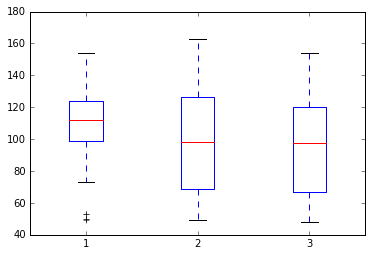

In [58]:
edges = [0, 0.125, 0.25, 0.4]
plt.boxplot([pya[(pxa > lower) & (pxa <= upper)] for lower, upper in zip(edges[:-1], edges[1:])]);

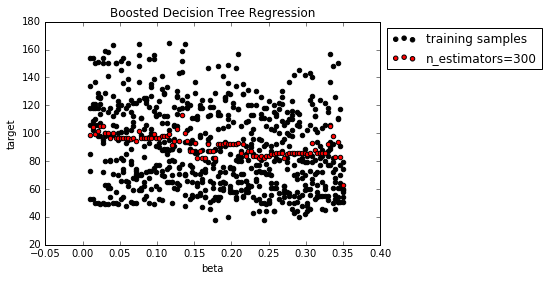

In [34]:
# randomness is necessary, but not much - it's generally a negative trend
# the right amount is the smallest amount possible that has any effect

y_pred = regr.predict(h_model_data[h_model_data['Season'] == holdout_season][['beta']])

axis_feature = 'beta'

plt.figure()
px, py = zip(*sorted(zip(X[axis_feature], y)))
plt.scatter(px, py, c="k", label="training samples")
px, py_pred = zip(*sorted(zip(X[axis_feature], y_pred)))
plt.scatter(px, py_pred, c="r", label="n_estimators=300")
plt.xlabel(axis_feature)
plt.ylabel("target")
plt.title("Boosted Decision Tree Regression")
plt.legend(bbox_to_anchor=(1.5, 1.0))
plt.show()

/Users/rsharp/PROJECTS/rws_project_python/lib/python2.7/site-packages/ipykernel/__main__.py:2: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 700 but corresponding boolean dimension is 100
  from ipykernel import kernelapp as app


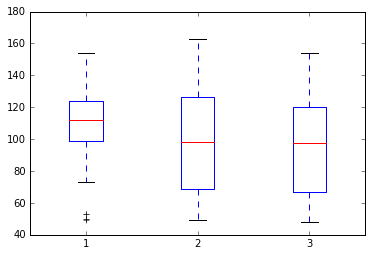

In [44]:
edges = [0, 0.125, 0.25, 0.4]
plt.boxplot([pya[(pxa > lower) & (pxa <= upper)] for lower, upper in zip(edges[:-1], edges[1:])]);

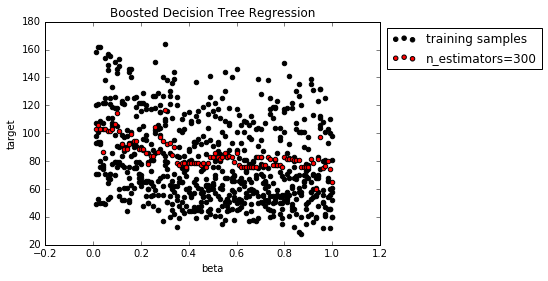

In [20]:
# randomness is necessary, but not much - it's generally a negative trend
# the right amount is the smallest amount possible that has any effect

y_pred = regr.predict(h_model_data[h_model_data['Season'] == holdout_season][['beta']])

axis_feature = 'beta'

plt.figure()
px, py = zip(*sorted(zip(X[axis_feature], y)))
plt.scatter(px, py, c="k", label="training samples")
px, py_pred = zip(*sorted(zip(X[axis_feature], y_pred)))
plt.scatter(px, py_pred, c="r", label="n_estimators=300")
plt.xlabel(axis_feature)
plt.ylabel("target")
plt.title("Boosted Decision Tree Regression")
plt.legend(bbox_to_anchor=(1.5, 1.0))
plt.show()

In [ ]:
# what happens with a positive ocrrelation on streaks?

y_pred = regr.predict(h_model_data[h_model_data['Season'] == holdout_season][['alpha']])

axis_feature = 'alpha'

plt.figure()
px, py = zip(*sorted(zip(X[axis_feature], y)))
plt.scatter(px, py, c="k", label="training samples")
px, py_pred = zip(*sorted(zip(X[axis_feature], y_pred)))
plt.scatter(px, py_pred, c="r", label="n_estimators=300")
plt.xlabel(axis_feature)
plt.ylabel("target")
plt.title("Boosted Decision Tree Regression")
plt.legend(bbox_to_anchor=(1.5, 1.0))
plt.show()



In [ ]:
# what happens with a positive ocrrelation on streaks?

y_pred = regr.predict(h_model_data[h_model_data['Season'] == holdout_season][['alpha']])

axis_feature = 'alpha'

plt.figure()
px, py = zip(*sorted(zip(X[axis_feature], y)))
plt.scatter(px, py, c="k", label="training samples")
px, py_pred = zip(*sorted(zip(X[axis_feature], y_pred)))
plt.scatter(px, py_pred, c="r", label="n_estimators=300")
plt.xlabel(axis_feature)
plt.ylabel("target")
plt.title("Boosted Decision Tree Regression")
plt.legend(bbox_to_anchor=(1.5, 1.0))
plt.show()



In [ ]:
# only use a dash of randomness
# randomnes is a binary question

y_pred = regr.predict(h_model_data[h_model_data['Season'] == holdout_season][['beta']])

axis_feature = 'beta'

plt.figure()
px, py = zip(*sorted(zip(X[axis_feature], y)))
plt.scatter(px, py, c="k", label="training samples")
px, py_pred = zip(*sorted(zip(X[axis_feature], y_pred)))
plt.scatter(px, py_pred, c="r", label="n_estimators=300")
plt.xlabel(axis_feature)
plt.ylabel("target")
plt.title("Boosted Decision Tree Regression")
plt.legend(bbox_to_anchor=(1.5, 1.0))
plt.show()

In [ ]:
# randomness is necessary, but not much - it's generally a negative trend
# the right amount is the smallest amount possible that has any effect

y_pred = regr.predict(h_model_data[h_model_data['Season'] == holdout_season][['beta']])

axis_feature = 'beta'

plt.figure()
px, py = zip(*sorted(zip(X[axis_feature], y)))
plt.scatter(px, py, c="k", label="training samples")
px, py_pred = zip(*sorted(zip(X[axis_feature], y_pred)))
plt.scatter(px, py_pred, c="r", label="n_estimators=300")
plt.xlabel(axis_feature)
plt.ylabel("target")
plt.title("Boosted Decision Tree Regression")
plt.legend(bbox_to_anchor=(1.5, 1.0))
plt.show()

In [ ]:
y_pred = regr.predict(h_model_data[h_model_data['Season'] == holdout_season][['alpha']])

axis_feature = 'alpha'

plt.figure()
px, py = zip(*sorted(zip(X[axis_feature], y)))
plt.scatter(px, py, c="k", label="training samples")
px, py_pred = zip(*sorted(zip(X[axis_feature], y_pred)))
plt.scatter(px, py_pred, c="r", label="n_estimators=300")
plt.xlabel(axis_feature)
plt.ylabel("target")
plt.title("Boosted Decision Tree Regression")
plt.legend(bbox_to_anchor=(1.5, 1.0))
plt.show()



In [ ]:
trials = 100

beta = 0.05

score_data = dict([(f, list()) for f in ['Season', 'alpha', 'beta', 'streak', 'score']])

for season in range(2010, 2017+1):
    print season
    for alpha in [-0.2, -0.1, 0.0]:
        for streak_len in [6, 10]:
            for i in range(trials):
                w = streak[(streak['Season'] == season) & (streak['StreakLen'] == streak_len)] \
                    .merge(polls[['TeamID', 'Season', 'norm_rank', 'noise']], on=['Season', 'TeamID'], how='left') \
                    .sort_values('norm_rank')

                w['Rank'] = w['norm_rank'] - alpha*w['streak'] + beta*(numpy.random.random(w.shape[0]) - 0.5)
                # w['Rank'] = w['norm_rank'] - alpha*w['streak']
                # w['Rank'] = w['norm_rank'] + beta*(numpy.random.random(w.shape[0]) - 0.5)
                w['alpha'] = alpha
                w['beta'] = beta
                w['streak'] = streak_len
                w['Season'] = season

                score = score_bracket(season, w[['TeamID', 'Rank']], rounds_by_season, weights)

                score_data['Season'].append(season)
                score_data['alpha'].append(alpha)
                score_data['beta'].append(beta)
                score_data['streak'].append(streak_len)
                score_data['score'].append(score)

score_data = pandas.DataFrame(score_data)

In [ ]:
gb = score_data.groupby(['Season', 'alpha', 'beta', 'streak'])
gb.quantile(0.75)

In [ ]:
plt.figure(figsize=(20,10))

plt_data = list()

for season in range(2010, 2017+1):
    #plt_data.append(list(score_data[(score_data['alpha'] ==  0.0) & (score_data['streak'] ==  6) & (score_data['Season'] == season)]['score']))
    plt_data.append(list(score_data[(score_data['alpha'] ==  -0.1) & (score_data['streak'] ==  6) & (score_data['Season'] == season)]['score']))
    #plt_data.append(list(score_data[(score_data['alpha'] ==  -0.2) & (score_data['streak'] ==  6) & (score_data['Season'] == season)]['score']))

    #plt_data.append(list(score_data[(score_data['alpha'] ==  0.0) & (score_data['streak'] ==  10) & (score_data['Season'] == season)]['score']))
    plt_data.append(list(score_data[(score_data['alpha'] ==  -0.1) & (score_data['streak'] ==  10) & (score_data['Season'] == season)]['score']))
    #plt_data.append(list(score_data[(score_data['alpha'] ==  -0.2) & (score_data['streak'] ==  10) & (score_data['Season'] == season)]['score']))

plt.boxplot(plt_data);